# Binarização de imagens

**Professor:** Bem-vindos à Binarização!

Até agora, trabalhamos com milhões de cores. Mas para uma máquina ler um texto (OCR) ou achar um código de barras, ela não precisa de cores. Ela muitas vezes só precisa de **SIM** (Objeto) ou **NÃO** (Fundo).

Binarizar é a arte de reduzir a complexidade. Transformar tons de cinza em Preto (0) e Branco (1 - ou 255 no OpenCV).

### O que vamos aprender:
1.  **Thresholding Global:** Quando um único valor serve para todos.
2.  **Otsu:** Como deixar a matemática encontrar o melhor corte sozinha.
3.  **Thresholding Adaptativo:** Lidando com sombras e iluminação ruim (estilo "Scanner de Documentos" do celular).



## 0) Setup e Utilitários
Reutilizando as ferramentas básicas do notebook anterior. Certifique-se de que o ambiente está com `opencv-python`, `matplotlib`, `numpy` e `scikit-image` instalados.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import data, img_as_float

# Configuração de plot
plt.rcParams['figure.figsize'] = (10, 6)

def show(img, title="", cmap=None):
    plt.figure(figsize=(6,6))
    if len(img.shape) == 2:
        plt.imshow(img, cmap='gray' if cmap is None else cmap)
    else:
        plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

## 1) O que é uma imagem binária e por que usamos?

Uma imagem binária possui apenas dois níveis de intensidade: **Preto (0)** e **Branco (1 ou 255)**. Conceitualmente, ela usa apenas **1 bit por pixel**.

### Por que simplificar tanto?
Ao reduzir a imagem a dois estados, estamos explicitando uma decisão semântica: o que é **Objeto de Interesse (Foreground)** e o que é **Fundo (Background)**. Isso é a forma mais primitiva e robusta de segmentação.

**Vantagens:**
- Extremamente leve (memória).
- Simplifica geometria: permite extrair contornos, esqueletos e formas facilmente.
- Essencial para OCR (Reconhecimento de Texto) e leitura de códigos de barra.

**Desvantagens:**
- Perda massiva de textura e detalhe.
- **Extrema sensibilidade à iluminação:** sombras podem ser confundidas com objetos escuros.

> **Insight Moderno:** Embora redes neurais hoje façam segmentação direto do RGB, algoritmos clássicos binários ainda dominam em velocidade e em ambientes controlados (fábricas, digitalização de documentos).

## 2) Pipeline: Cor -> Tons de Cinza -> Binário

Raramente binarizamos direto do RGB. O fluxo padrão é:
1. **RGB**: Imagem original.
2. **Grayscale**: Reduzimos a complexidade cromática, focando em luminância.
3. **Thresholding**: Aplicamos um limiar (threshold) $T$. Se pixel $> T$, vira Branco; senão, Preto.

Vamos usar uma imagem de texto digitalizada (`data.page()`) onde isso é crítico.

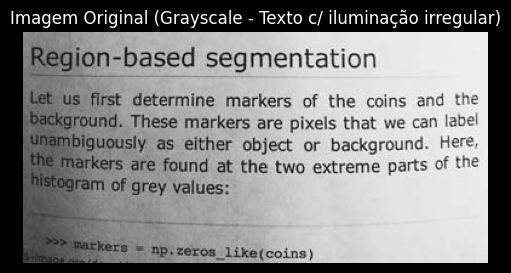

Shape: (191, 384), Min: 0, Max: 255


In [2]:
image = data.page()

# A imagem do skimage já vem como array 2D (grayscale), mas vamos garantir que é uint8 para o OpenCV
if image.dtype != np.uint8:
    # Normaliza se for float e converte
    image = (image * 255).astype(np.uint8)

show(image, "Imagem Original (Grayscale - Texto c/ iluminação irregular)")
print(f"Shape: {image.shape}, Min: {image.min()}, Max: {image.max()}")

## 3) Limiarização Simples (Global Thresholding)

**Professor:** A estratégia mais básica.
Nós (humanos) escolhemos um valor fixo **T** (Threshold/Limiar).
- Pixel > T $\rightarrow$ Branco (255)
- Pixel <= T $\rightarrow$ Preto (0)

> [!NOTE]
> É como uma prova escolar: Nota $\ge$ 5.0 passa, Nota < 5.0 reprova. Simples assim.
> Mas... e se a prova for muito difícil em uma parte da sala (iluminação ruim)?



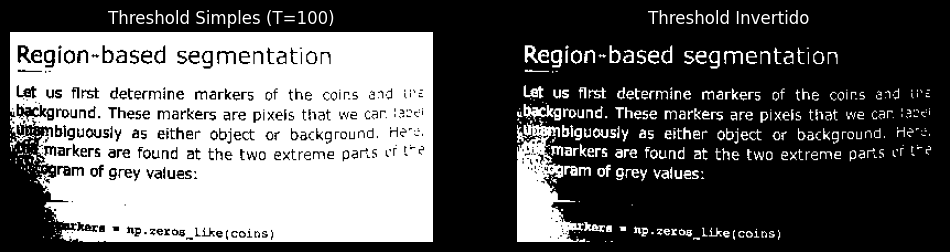

In [3]:
# Vamos tentar um limiar manual de 100
T = 100
_, binary_manual = cv2.threshold(image, T, 255, cv2.THRESH_BINARY)

# Invertido (Texto branco, fundo preto)
_, binary_inv = cv2.threshold(image, T, 255, cv2.THRESH_BINARY_INV)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(binary_manual, cmap='gray')
ax[0].set_title(f"Threshold Simples (T={T})")
ax[0].axis('off')

ax[1].imshow(binary_inv, cmap='gray')
ax[1].set_title("Threshold Invertido")
ax[1].axis('off')
plt.show()

**Problema:** Note como a sombra no canto da imagem afeta o resultado. Um valor fixo global falha quando a iluminação não é uniforme.

## 4) Limiarização Avançada: Otsu e Adaptativo

### A Intuição do Otsu (O "Valley Finder")
**Professor:** Como escolher o T perfeito sem chutar?
Imagine o Histograma da imagem como uma paisagem com duas montanhas: uma montanha de pixels escuros (Fundo) e uma de pixels claros (Texto).
O algoritmo de Otsu tenta encontrar matematicamente o **vale mais profundo** entre essas duas montanhas para passar a tesoura.

> [!TIP]
> Otsu funciona perfeitamente para imagens **bimodais** (histograma com dois picos claros). Ele minimiza a variância dentro das classes.

### E se tivermos sombras? (Adaptativo)
Se uma parte da folha está na sombra, o "branco" da sombra pode ser mais escuro que o "preto" da parte iluminada. Um T global falharia miseravelmente.
A solução é o **Limiar Adaptativo**: O computador calcula um **T diferente para cada pixel**, baseando-se na média dos seus vizinhos locais. É assim que apps de scanner removem sombras!



Otsu escolheu T = 157.0


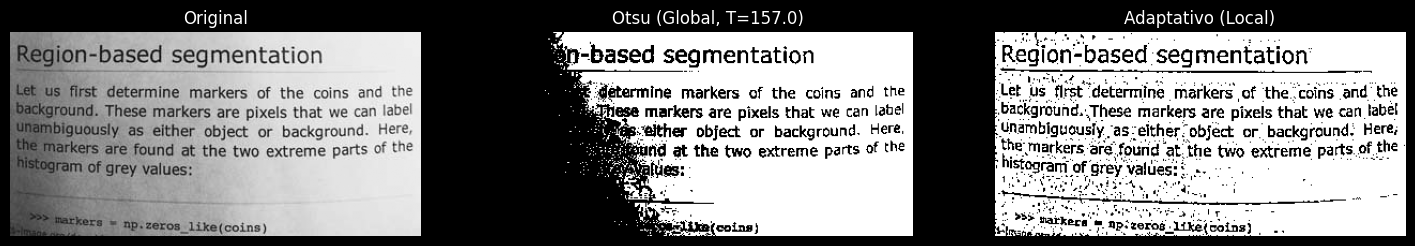

In [4]:
# 1. Otsu (Calcula T automaticamente)
# Passamos 0 como limiar e a flag THRESH_OTSU
val_otsu, binary_otsu = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
print(f"Otsu escolheu T = {val_otsu}")

# 2. Adaptativo (Gaussiano)
# blockSize: Tamanho da vizinhança (deve ser ímpar, ex: 15)
# C: Constante subtraída da média (ajuste fino)
binary_adaptive = cv2.adaptiveThreshold(
    image, 
    255, 
    cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    cv2.THRESH_BINARY,
    blockSize=15, 
    C=5
)

fig, ax = plt.subplots(1, 3, figsize=(18, 6))
ax[0].imshow(image, cmap='gray')
ax[0].set_title("Original")
ax[0].axis('off')

ax[1].imshow(binary_otsu, cmap='gray')
ax[1].set_title(f"Otsu (Global, T={val_otsu})")
ax[1].axis('off')

ax[2].imshow(binary_adaptive, cmap='gray')
ax[2].set_title("Adaptativo (Local)")
ax[2].axis('off')
plt.show()

### Análise
- **Otsu:** Melhor que o chute manual, mas ainda perdeu o texto na área sombreada.
- **Adaptativo:** Recuperou o texto na sombra perfeitamente, pois comparou o texto localmente com o fundo escuro daquela região. Porém, pode criar "ruído" em áreas muito limpas.

## Conclusão

Nesta aula, vimos que:
1. Imagens Binárias são a base para separar objetos.
2. O pipeline típico é `Cor -> Cinza -> Threshold`.
3. `Otsu` é ótimo para imagens controladas, mas `Adaptive Threshold` é o rei em cenários com iluminação real e variável.

Próximos passos: Usar essas imagens binárias para encontrar contornos e medir objetos!